# imports

In [1]:
!pip install adversarial-robustness-toolbox

You should consider upgrading via the '/Users/romansim/Учеба/ВКР_v2/Практика/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install torchattacks==3.3.0

  Using cached torchattacks-3.3.0-py3-none-any.whl (155 kB)
  Attempting uninstall: torchattacks
    Found existing installation: torchattacks 3.4.0
    Uninstalling torchattacks-3.4.0:
      Successfully uninstalled torchattacks-3.4.0
You should consider upgrading via the '/Users/romansim/Учеба/ВКР_v2/Практика/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import torchattacks

In [12]:
import time
import numpy as np 
import torch.nn as nn 
from datetime import datetime

from PIL import Image
from torchvision import transforms
import torchvision
import torch
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt 

from art.estimators.classification import PyTorchClassifier
from skimage.metrics import structural_similarity as ssim

import warnings
warnings.filterwarnings('ignore') 
import torch

from sklearn.datasets import fetch_lfw_people
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

# Dataset

In [5]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [6]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

n_components = 150

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [7]:
import matplotlib.pyplot as plt
from skimage import color
def show_images(images, targets, nrows=3, ncols=3):
    """
    Функция выводит изображения из датасета LFW People.

    Parameters:
    images (array-like): массив с изображениями.
    targets (array-like): массив с метками классов.
    nrows (int, optional): количество строк изображений в выводе. По умолчанию 3.
    ncols (int, optional): количество столбцов изображений в выводе. По умолчанию 3.
    """
    color.gray2rgba
    # images = images.reshape(-1, 50, 37)
    images = color.gray2rgb(images.reshape(-1, 50, 37))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Label: {targets[i]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


def show_image(image, target):
	"""
	Функция выводит изображение из датасета LFW People.
	Parameters:
	image (array-like): массив с изображением.
	target (array-like): массив с меткой класса.
	"""
	image = color.gray2rgb(image.reshape(-1, 50, 37))
	fig, ax = plt.subplots(1, 1, figsize=(3, 3))
	ax.imshow(image[0], cmap='gray')
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_title(target)
	plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


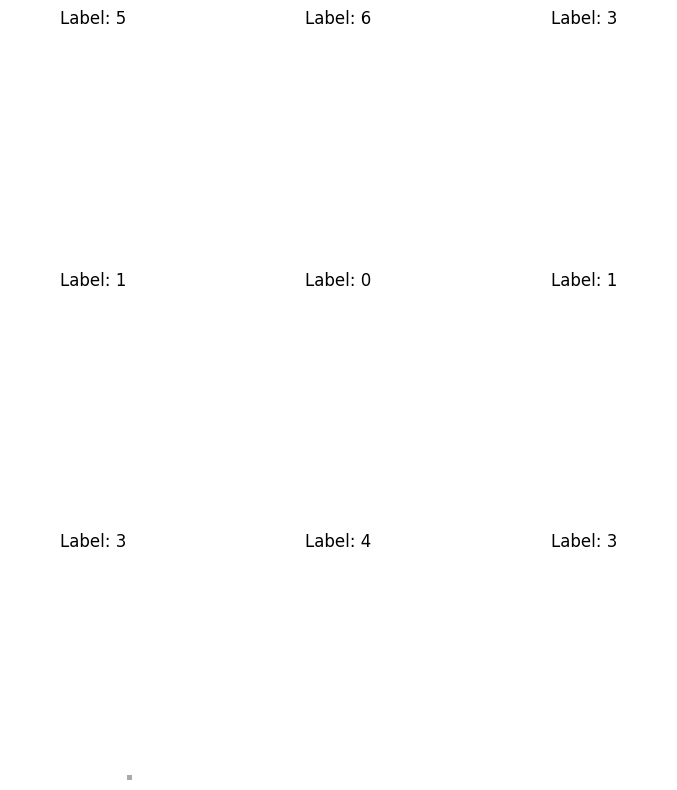

In [8]:
# X = lfw_people.images
# y = lfw_people.target
show_images(X, y, nrows=3, ncols=3)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25
)

In [10]:
X_train.shape

(966, 1850)

In [13]:
# create dataset and dataloader
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_dlpack(X_train).float(),
        torch.from_dlpack(y_train).long()
    ),
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_dlpack(X_test).float(),
        torch.from_dlpack(y_test).long()
    ),
    batch_size=batch_size,
    shuffle=False
)

RuntimeError: from_dlpack received an invalid capsule. Note that DLTensor capsules can be consumed only once, so you might have already constructed a tensor from it once.

# Model

In [12]:
from v0_1_my_custom_model import *

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(X_train, n_components=n_components, n_classes=n_classes)

In [14]:
def train(model, dataloader, criterion, optimizer, n_epochs, n_components, device):
    losses = []
    model.train()
    
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}")
        
        for batch_idx, (data, target) in enumerate(dataloader):
            data = data.to(device)
            target = target.to(device)
            
            # Нормализация данных
            scaler = StandardScaler()
            data = scaler.fit_transform(data.reshape(data.shape[0], -1))
            
            # Применение PCA
            pca = PCA(n_components=n_components)
            data = pca.fit_transform(data)
            data = torch.Tensor(data).to(device)
            
            # Прямой проход
            optimizer.zero_grad()
            output = model(data)
            
            # Вычисление функции потерь
            loss = criterion(output, target)
            losses.append(loss.item())
            
            # Обратный проход и оптимизация параметров
            loss.backward()
            optimizer.step()
            
    return losses

In [15]:
def train(model, device, train_loader, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        print(batch_idx, (data.shape, target.shape))
        model.optimizer.zero_grad()
        output = model(data)
        loss = model.criterion(output, target)
        loss.backward()
        model.optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += model.criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [16]:
print(X_train.shape)
pca = PCA(n_components=n_components)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
print(X_train_pca.shape)

(966, 1850)
(966, 150)


In [17]:
epochs = 40
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, epoch)
    test(model, device, test_loader)

0 (torch.Size([64, 1850]), torch.Size([64]))
Train Epoch: 1 [0/966 (0%)]	Loss: 1.801139
1 (torch.Size([64, 1850]), torch.Size([64]))
2 (torch.Size([64, 1850]), torch.Size([64]))
3 (torch.Size([64, 1850]), torch.Size([64]))
4 (torch.Size([64, 1850]), torch.Size([64]))
5 (torch.Size([64, 1850]), torch.Size([64]))
6 (torch.Size([64, 1850]), torch.Size([64]))
7 (torch.Size([64, 1850]), torch.Size([64]))
8 (torch.Size([64, 1850]), torch.Size([64]))
9 (torch.Size([64, 1850]), torch.Size([64]))
10 (torch.Size([64, 1850]), torch.Size([64]))
Train Epoch: 1 [640/966 (62%)]	Loss: 1.506323
11 (torch.Size([64, 1850]), torch.Size([64]))
12 (torch.Size([64, 1850]), torch.Size([64]))
13 (torch.Size([64, 1850]), torch.Size([64]))
14 (torch.Size([64, 1850]), torch.Size([64]))
15 (torch.Size([6, 1850]), torch.Size([6]))

Test set: Average loss: 0.0228, Accuracy: 187/322 (58%)

0 (torch.Size([64, 1850]), torch.Size([64]))
Train Epoch: 2 [0/966 (0%)]	Loss: 1.260351
1 (torch.Size([64, 1850]), torch.Size([64

In [18]:
test(model, device, test_loader)


Test set: Average loss: 0.0176, Accuracy: 264/322 (82%)



In [19]:
save_model(model, "model.pth")

In [20]:
X_test.shape

(322, 1850)

# Adversarial attack

In [21]:
!pip install torchattacks==3.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
import torchattacks

In [38]:
class Attack:
    def __init__(self, model, device, attack_type):
        self.model = model
        self.device = device
        self.attack_type = attack_type
        self.attack = None

    def __call__(self, x, y):
        if self.attack_type == 'FGSM':
            self.attack = torchattacks.FGSM(self.model, eps=8/255)
        elif self.attack_type == 'PGD':
            self.attack = torchattacks.PGD(self.model, eps=8/255, alpha=2/255, steps=25)
        elif self.attack_type == 'CW':
            self.attack = torchattacks.CW(self.model, steps=25, lr=0.01)
        elif self.attack_type == 'DeepFool':
            self.attack = torchattacks.DeepFool(self.model, steps=25, overshoot=0.02)
        elif self.attack_type == 'BIM':
            self.attack = torchattacks.BIM(self.model, eps=8/255, alpha=2/255, steps=25)
        elif self.attack_type == 'RFGSM':
            self.attack = torchattacks.RFGSM(self.model, eps=8/255, alpha=2/255, steps=25)
        
        x_adv = self.attack(x, y)
        return x_adv

In [53]:
def attack(model, device, method, loader) -> torch.Tensor:
  attack = Attack(model.model, device, method)
  x_adv = []
  x_data = []
  for batch_idx, (data, target) in enumerate(loader):
      data, target = data.to(device), target.to(device)
      x_data.append(torch.tensor(data, dtype=torch.float32))
      _data = model._processing(data)
      x_adv.append(torch.tensor(model._reverse_processing(attack(_data, target)), dtype=torch.float32))
  print("END 1")
  print(x_adv[0].shape)
  # x_adv_tensor = torch.tensor(x_adv, dtype=torch.float32)
  x_data = torch.cat(x_data, dim=0)
  x_adv = torch.cat(x_adv, dim=0)
  print("END 2")
  test_loader_adv = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.from_dlpack(x_adv).float(),
        torch.from_dlpack(y_test).long()
    ),
    batch_size=batch_size,
    shuffle=False
  )
  print("END 3")
  test(model, device, test_loader_adv)
  return x_data, x_adv, y_test

END 1
torch.Size([64, 1850])
END 2
END 3

Test set: Average loss: 0.0226, Accuracy: 177/322 (55%)



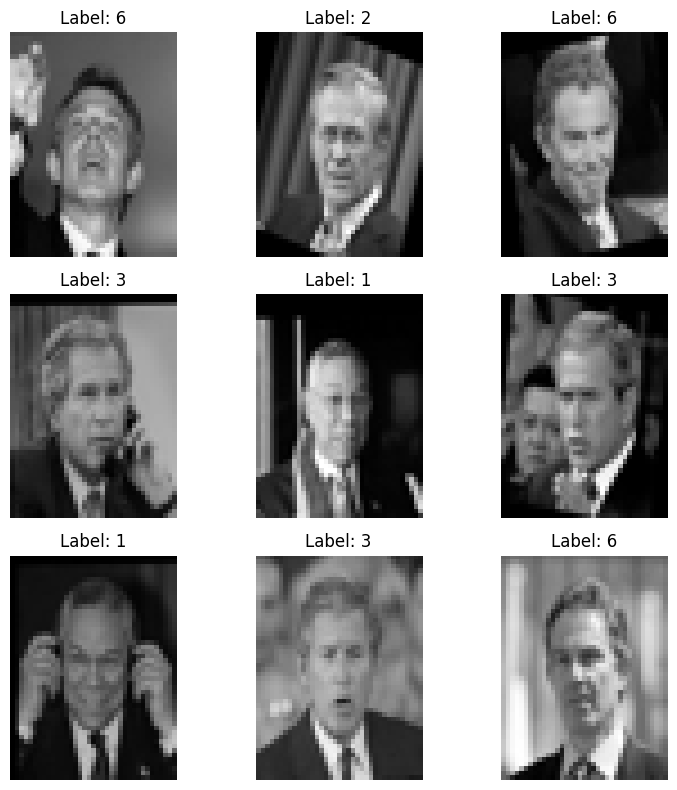

In [55]:
x, x_adv, y = attack(model, device, "FGSM", test_loader)
show_images(x, y)

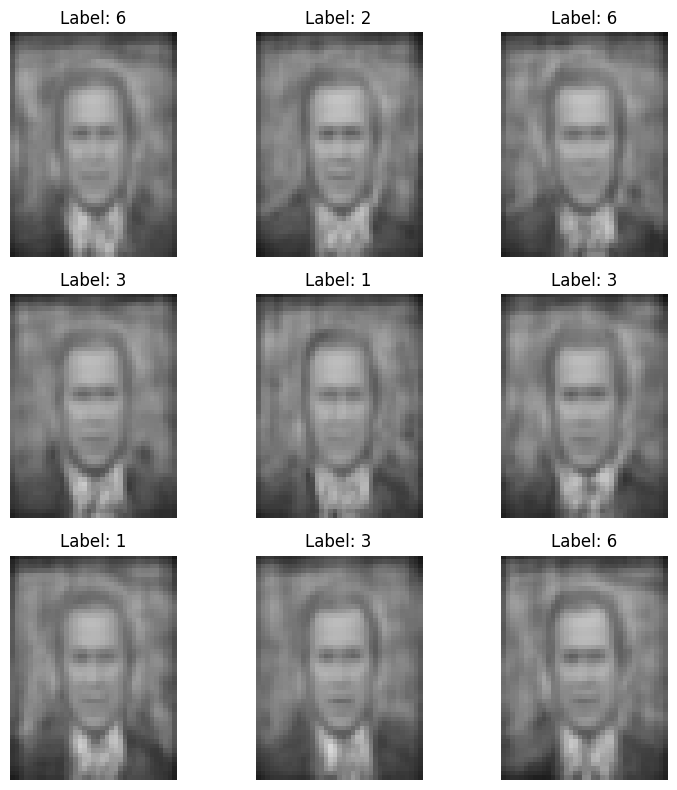

In [56]:
show_images(x_adv, y)

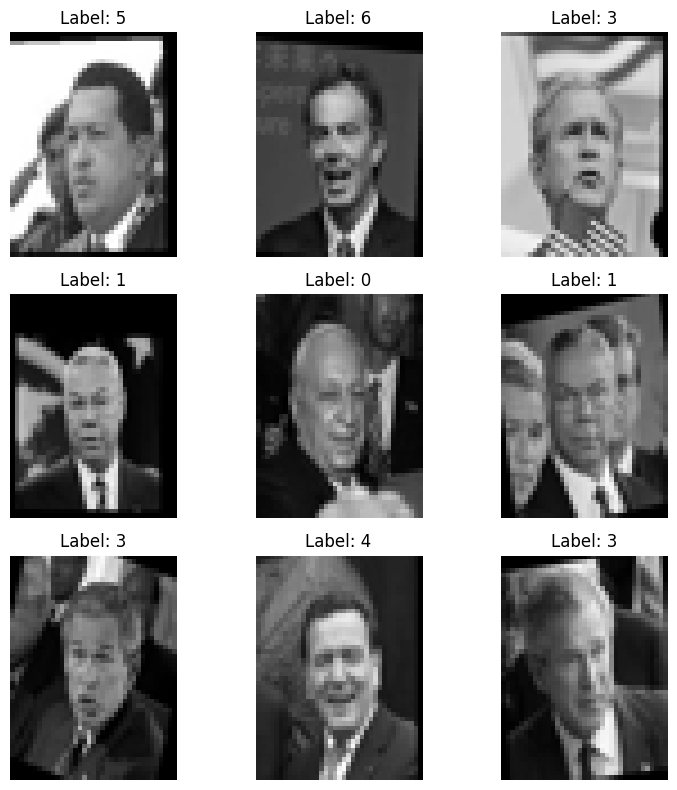

In [44]:
show_images(X, y, nrows=3, ncols=3)

END 1
torch.Size([64, 1850])
END 2
END 3

Test set: Average loss: 0.0230, Accuracy: 174/322 (54%)



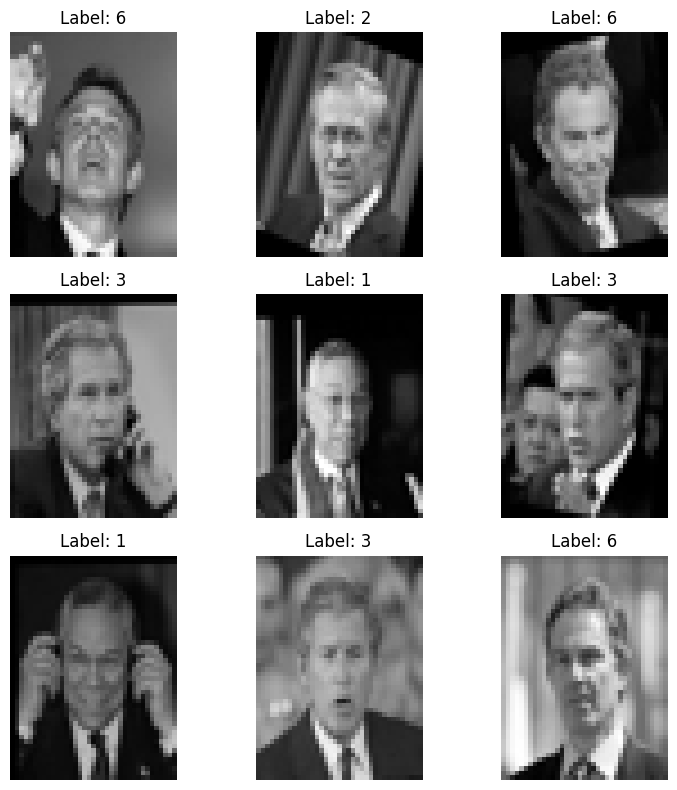

In [57]:
x, x_adv, y = attack(model, device, "PGD", test_loader)
show_images(x, y)

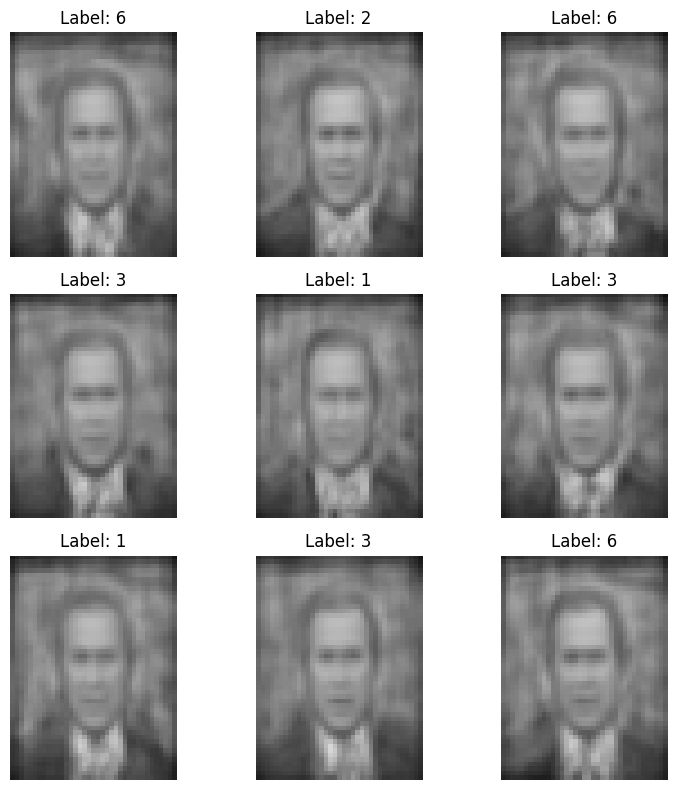

In [58]:
show_images(x_adv, y)

In [59]:
x, x_adv, y = attack(model, device, "CW", test_loader)
show_images(x, y)

END 1
torch.Size([64, 1850])
END 2
END 3


ValueError: ignored

In [ ]:
show_images(x_adv, y)

END 1
torch.Size([64, 1850])
END 2
END 3

Test set: Average loss: 0.0483, Accuracy: 39/322 (12%)



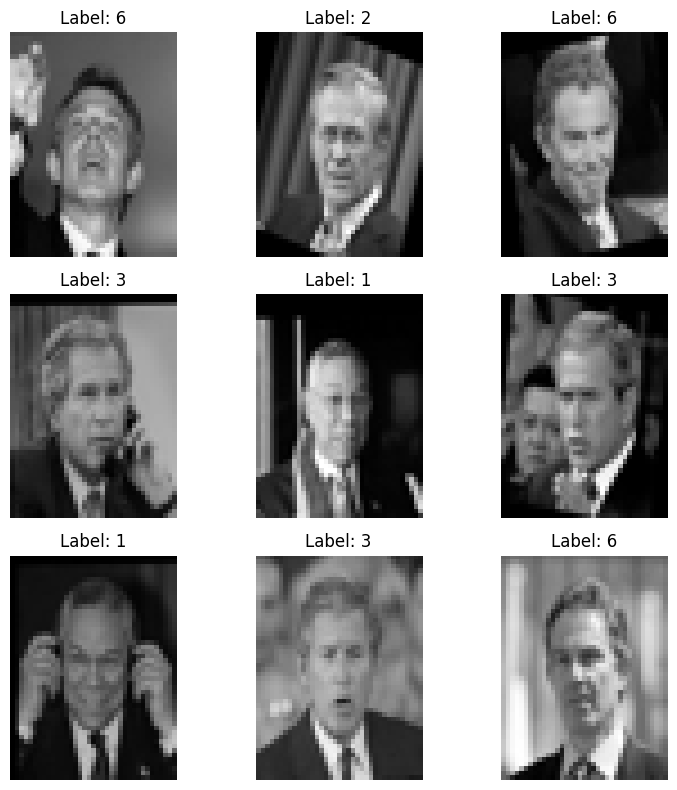

In [60]:
x, x_adv, y = attack(model, device, "DeepFool", test_loader)
show_images(x, y)

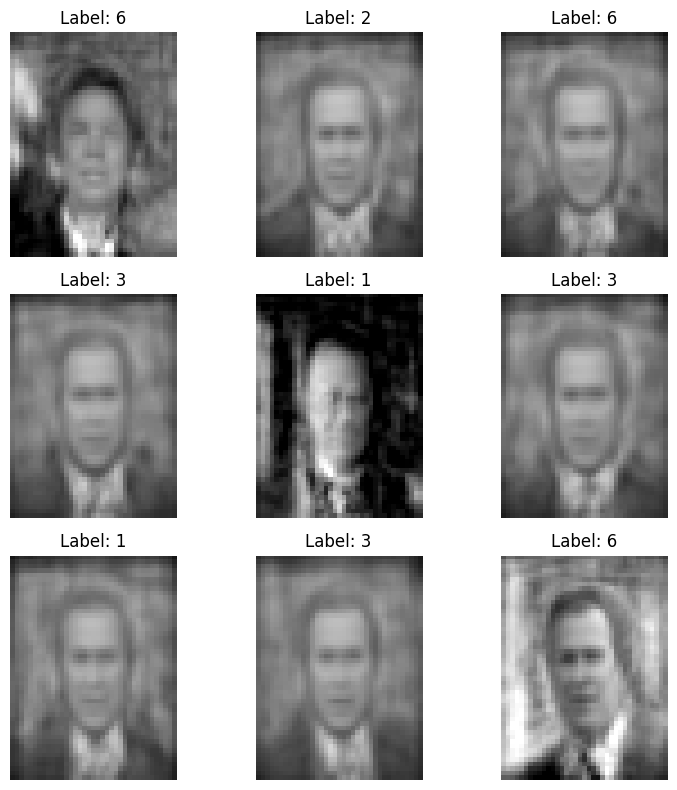

In [61]:
show_images(x_adv, y)

END 1
torch.Size([64, 1850])
END 2
END 3

Test set: Average loss: 0.0369, Accuracy: 203/322 (63%)



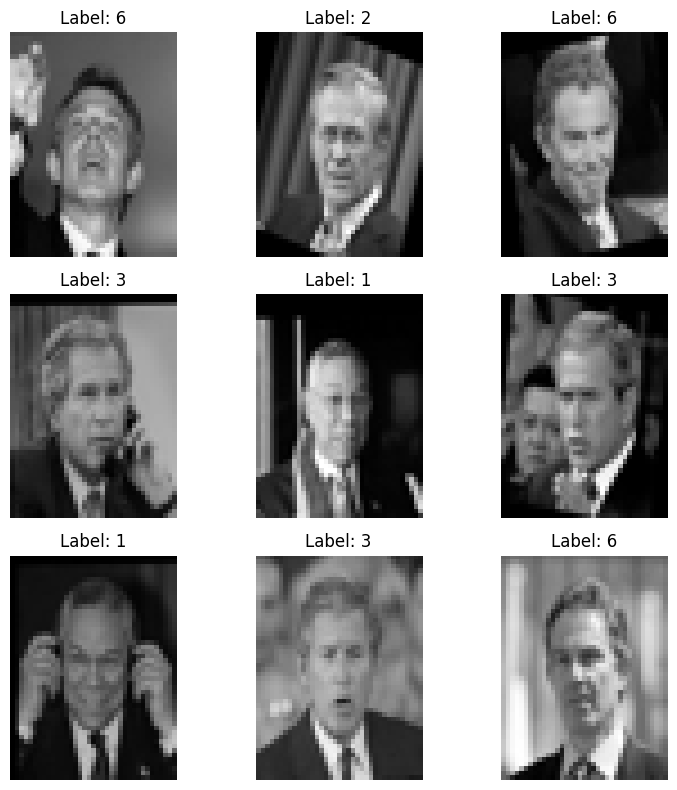

In [62]:
x, x_adv, y = attack(model, device, "BIM", test_loader)
show_images(x, y)

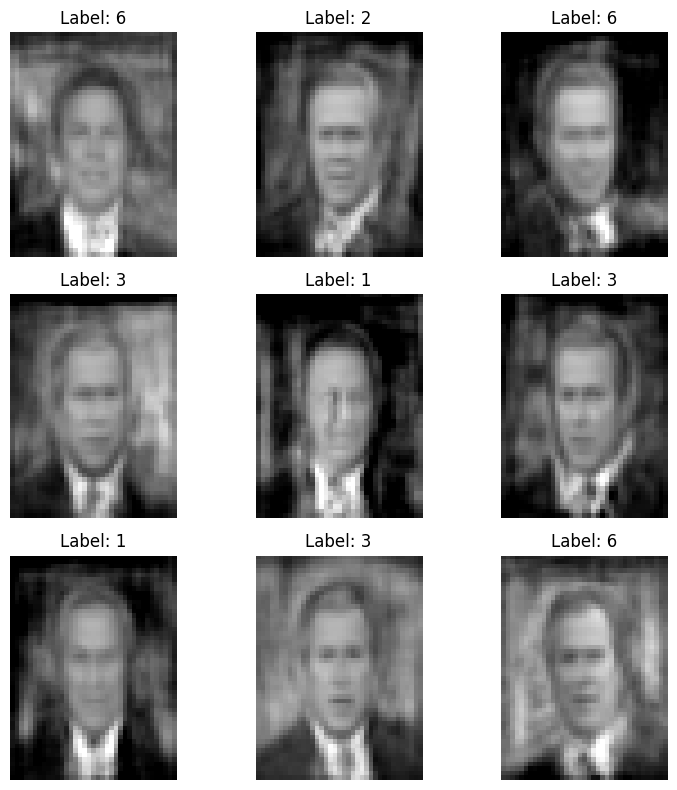

In [63]:
show_images(x_adv, y)

END 1
torch.Size([64, 1850])
END 2
END 3

Test set: Average loss: 0.0230, Accuracy: 174/322 (54%)



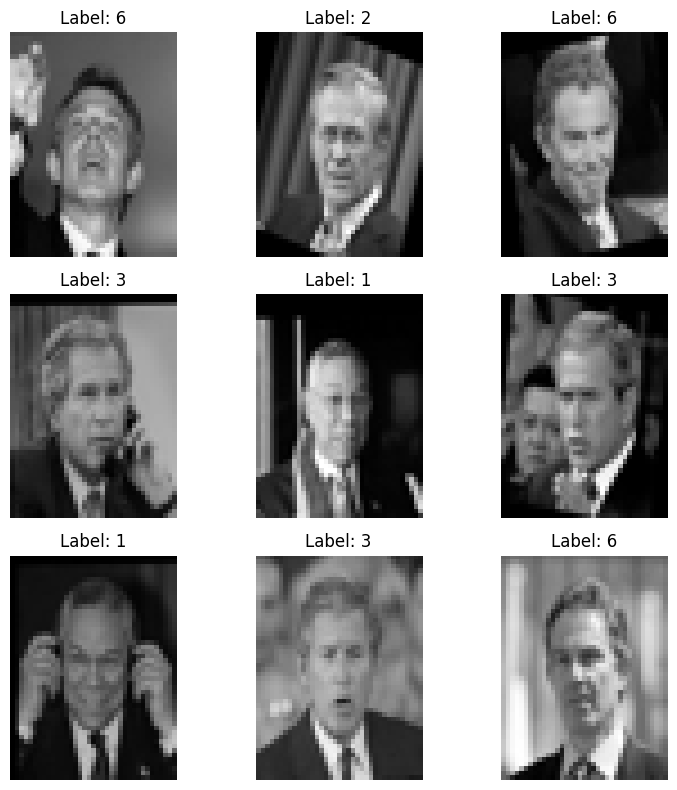

In [64]:
x, x_adv, y = attack(model, device, "RFGSM", test_loader)
show_images(x, y)

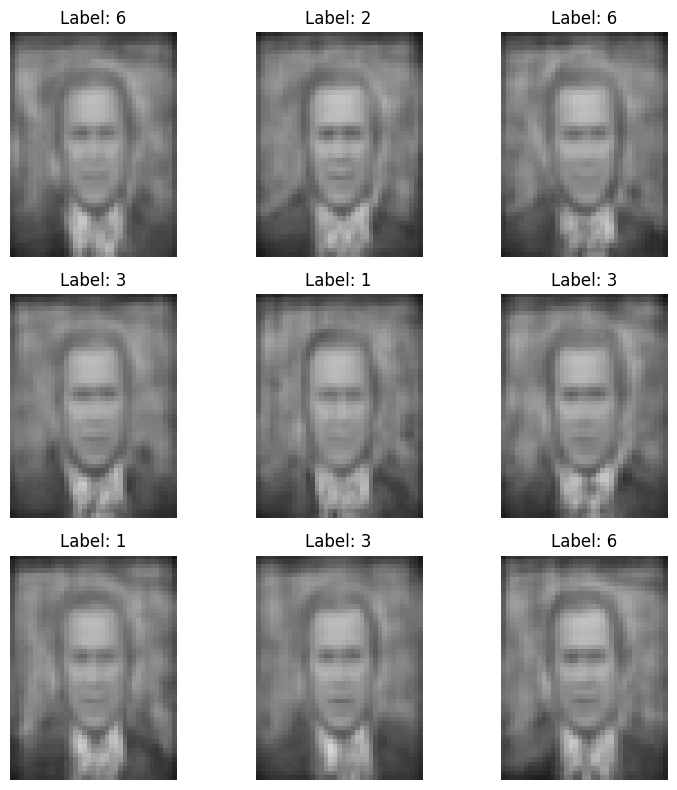

In [65]:
show_images(x_adv, y)